# Model Predictive Control of Hybrid Systems

In this notebook we extend the example presented in $\texttt{hybrid_mpc.ipynb}$ considering a more complex system: a cart-pole with two elastic walls.

## Demo

In [1]:
# notebook settings
%load_ext autoreload
%autoreload 2

# external imports
import numpy as np
import matplotlib.pyplot as plt

# internal imports
from pympc.geometry.polyhedron import Polyhedron
from pympc.dynamics.discrete_time_systems import LinearSystem, AffineSystem, PieceWiseAffineSystem
# from pympc.control.controllers_socp import HybridModelPredictiveController
# from pympc.control.controllers_gurobi import HybridModelPredictiveController
from pympc.control.hybrid_benchmark.controllers import HybridModelPredictiveController
from pympc.plot import plot_input_sequence, plot_output_trajectory

We stabilize a linearized cart-pole with: cart of mass $m_{\mathrm{c}}$, pole of mass $m_{\mathrm{p}}$, pole of length $l$, and subject to the gravity acceleration $g$; the pole is allowed to impact with two elastic walls with stiffness $k$ placed at distance $d$ from the origin

In [2]:
mc = .1
mp = 1.
l = 1.
d = 1.
k = 500.
mu = 50.
g = 10.
h = .05

We express the linearized dynamics in PieceWise Affine (PWA) form
\begin{align}
x(t+1) = A_i x(t) + B_i u(t) + c_i
\quad \text{if} \quad
(x(t),u(t)) \in \mathcal D_i
,
\quad i \in \{ 1, \ldots, s\}
\end{align}


In [3]:
# discretization method
method = 'zero_order_hold'

# dynamics n.1 (penetration with left wall)
A1 = np.array([
    [0., 0., 1., 0.],
    [0., 0., 0., 1.],
    [0., (g*mp)/mc, 0., 0.],
    [k/(l*mp), (g*mp)/(l*mc) + g/l - k/mp, mu/(l*mp), -mu/mp]
    ])
B1 = np.array([
    [0.],
    [0.],
    [1./mc],
    [1./(l*mc)]
    ])
c1 = np.array([
    [0.],
    [0.],
    [0.],
    [(k*d)/(l*mp)]
    ])
S1 = AffineSystem.from_continuous(A1, B1, c1, h, method)

# dynamics n.2,3,4 (contact forces vanish)
A234 = np.array([
    [0., 0., 1., 0.],
    [0., 0., 0., 1.],
    [0., (g*mp)/mc, 0., 0.],
    [0., g*(mc+mp)/(l*mc), 0., 0.]
    ])
B234 = np.array([
    [0.],
    [0.],
    [1./mc],
    [1./(l*mc)]
    ])
S234 = LinearSystem.from_continuous(A234, B234, h, method)

# dynamics n.5 (penetration with right wall)
A5 = np.array([
    [0., 0., 1., 0.],
    [0., 0., 0., 1.],
    [0., (g*mp)/mc, 0., 0.],
    [k/(l*mp), (g*mp)/(l*mc) + g/l - k/mp, mu/(l*mp), -mu/mp]
    ])
B5 = np.array([
    [0.],
    [0.],
    [1./mc],
    [1./(l*mc)]
    ])
c5 = np.array([
    [0.],
    [0.],
    [0.],
    [-(k*d)/(l*mp)]
    ])
S5 = AffineSystem.from_continuous(A5, B5, c5, h, method)

# list of dynamics
S_list = [S1, S234, S234, S234, S5]

The domains of the PWA must be expressed as (bounded!) polyhedra

In [4]:
# state bounds
x_max = np.array([[d], [np.pi/6.], [5.], [3.]])
x_min = - x_max

# state domain n.1 (penetration with left wall, wall not pulling)
X1 = Polyhedron.from_bounds(x_min, x_max)
X1.add_inequality(
    np.array([[1., -l, 0., 0.]]),
    np.array([[-d]])
) # top of the pole touching the left wall
X1.add_inequality(
    np.array([[k, -k*l, mu, -mu*l]]),
    np.array([[-k*d]])
) # wall not pulling
assert X1.bounded
assert not X1.empty

# state domain n.2 (penetration with left wall, wall pulling)
X2 = Polyhedron.from_bounds(x_min, x_max)
X2.add_inequality(
    np.array([[1., -l, 0., 0.]]),
    np.array([[-d]])
) # top of the pole touching the left wall
X2.add_inequality(
    np.array([[-k, k*l, -mu, mu*l]]),
    np.array([[k*d]])
) # wall pulling
assert X2.bounded
assert not X2.empty

# state domain n.3 (between the two walls)
X3 = Polyhedron.from_bounds(x_min, x_max)
X3.add_inequality(
    np.array([[-1., l, 0., 0.], [1., -l, 0., 0.]]),
    np.array([[d], [d]])
) # top of the pole not touching any wall
assert X3.bounded
assert not X3.empty

# state domain n.4 (penetration with right wall, wall pulling)
X4 = Polyhedron.from_bounds(x_min, x_max)
X4.add_inequality(
    np.array([[-1., l, 0., 0.]]),
    np.array([[-d]])
) # top of the pole touching the right wall
X4.add_inequality(
    np.array([[k, -k*l, mu, -mu*l]]),
    np.array([[k*d]])
) # wall pulling
assert X4.bounded
assert not X4.empty

# state domain n.5 (penetration with right wall, wall not pulling)
X5 = Polyhedron.from_bounds(x_min, x_max)
X5.add_inequality(
    np.array([[-1., l, 0., 0.]]),
    np.array([[-d]])
) # top of the pole touching the right wall
X5.add_inequality(
    np.array([[-k, k*l, -mu, mu*l]]),
    np.array([[-k*d]])
) # wall not pulling
assert X5.bounded
assert not X5.empty

# list of state domains
X = [X1, X2, X3, X4, X5]

# input domain
u_max = np.array([[.4]])
u_min = - u_max
U = Polyhedron.from_bounds(u_min, u_max)

# domains
D_list = [Xi.cartesian_product(U) for Xi in X]

The overall PWA system can be defines as follows

In [5]:
S = PieceWiseAffineSystem(S_list, D_list)

Now we have all the ingredients to build the MPC controller

In [11]:
# controller parameters
N = 5
Q = np.eye(S.nx)
R = np.eye(S.nu)

# terminal set and cost
P, K = S234.solve_dare(Q, R)
X_N = S234.mcais(K, D_list[2], verbose=True)

# hybrid controller
controller = HybridModelPredictiveController(S, N, Q, R, P, X_N, 'convex_hull')

Time horizon: 13. Convergence index: -0.0005985788164660777. Number of facets: 54.   
Maximal constraint-admissible invariant set found.
Removing redundant facets ... minimal facets are 36.


We can now simulate the closed-loop dynamics starting from the initial state $x_0$.

In [ ]:
x0 = np.array([[.0], [0.], [-2.], [.0]])

u, x, ms, cost = controller.feedforward(x0, draw_solution=True)
print cost
print ms

controller.set_initial_condition(x0)
sol = controller.solve_relaxation([2, 2, 2, 2, 2, 2, 2, 2, 2])
print sol['cost']

In [ ]:
u, x, ms, cost = controller.feedforward(x0)
print cost
print ms

tic = time()
u, x, ms, cost = controller.feedforward_bm(x0)
print time() - tic
print cost
print ms

We can use the plot functions to visualize the time evolution of the system

In [ ]:
# input
plot_input_sequence(u, h, (u_min, u_max))
plt.show()

# output (horizontal position of the tip of the pole)
C = np.array([[1., -l, 0., 0.]])
y_min = np.array([[-d]])
y_max = np.array([[d]])
plot_output_trajectory(C, x, h, (y_min, y_max))
plt.show()

## Animate results with MeshCat

Now we animate the closed-loop trajectory of the cart-pole with MeshCat (see https://github.com/rdeits/meshcat-python)

In [ ]:
import time
import meshcat
import meshcat.geometry as g
import meshcat.transformations as tf

Create a new visualizer

In [ ]:
vis = meshcat.Visualizer()

Create the cart-pole

In [ ]:
# cart-pole
cart_pole = vis["cart_pole"]

# cart
cart = cart_pole["cart"]
cart.set_object(g.Box([.3*l, .3*l, .3*l]), g.MeshLambertMaterial(color=0xff2222))

# pivot
pivot = cart["pivot"]
pivot.set_transform(tf.rotation_matrix(np.pi/2, [1, 0., 0.]))

# pole
pole = pivot["pole"]
pole.set_object(g.Box([.05*l, l, .05*l]), g.MeshLambertMaterial(color=0x2222ff))
pole.set_transform(tf.translation_matrix([0., .5, 0.]))

# left wall
left_wall = vis["left_wall"]
left_wall.set_object(g.Box([l, .05*l, l]), g.MeshLambertMaterial(color=0x22ff22))
left_wall.set_transform(tf.translation_matrix([0., -d, l]))

# right wall
right_wall = vis["right_wall"]
right_wall.set_object(g.Box([l, .05*l, l]), g.MeshLambertMaterial(color=0x22ff22))
right_wall.set_transform(tf.translation_matrix([0., d, l]))

Animate the results

In [ ]:
# visualization function
def visualize_cart_pole(x):
    cart.set_transform(tf.translation_matrix([0, x[0,0], 0]))
    pivot.set_transform(tf.rotation_matrix(x[1,0] + np.pi/2, [1, 0, 0]))
vis.jupyter_cell()

In [ ]:
# animation
for t in range(N):
    visualize_cart_pole(x[t])
    time.sleep(h)

In [ ]:
import itertools
import scipy.sparse

def extract_linear_equalities(prog):
    bindings = prog.linear_equality_constraints()
    C = np.zeros((len(bindings), prog.num_vars()))
    d = np.zeros(len(bindings))
    for (i, binding) in enumerate(bindings):
        constraint = binding.evaluator()
        ci = np.zeros(prog.num_vars())
        assert constraint.upper_bound() == constraint.lower_bound()
        d[i] = constraint.upper_bound()
        ai = constraint.A()
        assert ai.shape[0] == 1
        ai = ai[0, :]
        for (j, var) in enumerate(binding.variables()):
            ci[prog.FindDecisionVariableIndex(var)] = ai[j]
        C[i, :] = ci
    return C, d

def extract_linear_inequalities(prog):
    bindings = itertools.chain(prog.linear_constraints(), prog.bounding_box_constraints())
    if not bindings:
        return np.zeros((0, prog.num_vars())), np.zeros(0)
    A = []
    b = []
    for (i, binding) in enumerate(bindings):
        constraint = binding.evaluator()
        A_row = np.zeros(prog.num_vars())
        ai = constraint.A()
        assert ai.shape[0] == 1
        ai = ai[0, :]
        for (j, var) in enumerate(binding.variables()):
            A_row[prog.FindDecisionVariableIndex(var)] = ai[j]

        if constraint.upper_bound() != np.inf:
            A.append(A_row)
            b.append(constraint.upper_bound())
        if constraint.lower_bound() != -np.inf:
            A.append(-A_row)
            b.append(-constraint.lower_bound())
    return np.vstack(A), np.hstack(b)

def extract_objective(prog):
    num_vars = prog.num_vars()
    Q = np.zeros((num_vars, num_vars))
    q = np.zeros(num_vars)

    for binding in prog.linear_costs():
        var_order = [prog.FindDecisionVariableIndex(v) for v in binding.variables()]
        ai = binding.evaluator().A()
        assert ai.shape[0] == 1
        ai = ai[0, :]
        for i in range(ai.size):
            q[var_order[i]] += ai[i]

    for binding in prog.quadratic_costs():
        var_order = [prog.FindDecisionVariableIndex(v) for v in binding.variables()]
        Qi = binding.evaluator().Q()
        bi = binding.evaluator().b()
        for i in range(bi.size):
            q[var_order[i]] += bi[i]
            for j in range(bi.size):
                Q[var_order[i], var_order[j]] += Qi[i, j]
    Q = 0.5 * (Q + Q.T)
    return Q, q

In [ ]:
controller = HybridModelPredictiveController(S, N, Q, R, P, X_N, 'big_m')
controller.set_initial_condition(x0)
C, d = extract_linear_equalities(controller.prog)
D, e = extract_linear_inequalities(controller.prog)
H, q = extract_objective(controller.prog)

In [ ]:
plt.spy(scipy.sparse.csc_matrix(H))
plt.show()
plt.spy(scipy.sparse.csc_matrix(D))
plt.show()
plt.spy(scipy.sparse.csc_matrix(C))
plt.show()

In [ ]:
import osqp
m = osqp.OSQP()
A = scipy.sparse.csc_matrix(np.vstack((D, C)))
l = np.concatenate((np.repeat(-np.inf, e.size), d))
u = np.concatenate((e, d))
m.setup(P=scipy.sparse.csc_matrix(H), q=q, A=A, l=l, u=u)#, verbose=False)

In [ ]:
results = m.solve()

In [ ]:
e_new = e.copy()
e_new[1038] = -1.
m.update(u=np.concatenate((e_new, d)))

In [ ]:
results = m.solve()

In [ ]:
controller = HybridModelPredictiveController(S, N, Q, R, P, X_N, 'big_m')
#a = controller.solve_relaxation([])

In [ ]:
import time
itc = time.time()
a = controller.solve_relaxation([0])
print time.time() - itc 

In [ ]:
from pympc.optimization.solvers.gurobi import quadratic_program

In [ ]:
print D.shape
D[1038][104]

# AAA

In [12]:
# feasible set (ball position and velocity)
from pympc.control.hybrid_benchmark.utils import get_constraint_set
controller.reset_program()
CS = get_constraint_set(controller.prog)
sect = CS.project_to([0,1])

# # feasible set section (given paddle velocity)
# v = np.array([[0.],[0.]])
# A_sect = CS.A[:, 2:]
# b_sect = CS.b + CS.A[:, :2].dot(v)
# CS_sect = Polyhedron(A_sect, b_sect)
# sect = CS_sect.project_to([0,1])

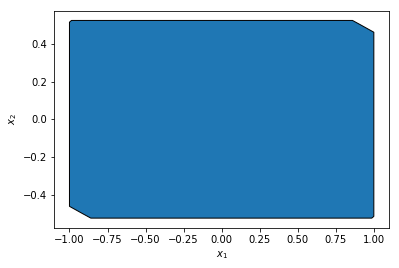

In [13]:
sect.plot()